# Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

# Datos

In [2]:
base_dir = r'./data/raw'
folders = os.listdir(base_dir)
print(folders)

['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

datagenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
train_generator = datagenerator.flow_from_directory(
    base_dir,
    target_size=(250 , 250),
    batch_size=32,
    subset='training',
)

test_generator = datagenerator.flow_from_directory(
    base_dir,
    target_size=(250 , 250),
    batch_size=32,
    subset='validation',
)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


# Preparación Red Neuronal

In [4]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout

inputs = Input(shape=(250, 250, 3))

x = Conv2D(32, (5,5), activation = 'relu')(inputs)
x = MaxPooling2D(3,3)(x)
x = Conv2D(64, (5,5) , activation = 'relu')(x)
x = MaxPooling2D((3,3))(x)
x = Conv2D(128 , (5,5) , activation = 'relu')(x)
x = MaxPooling2D(3,3)(x)
x = Flatten()(x)
x = Dropout(0.5, seed = 5)(x)
x = Dense(128 , activation = 'relu')(x)

outputs = Dense(4, activation = 'softmax')(x)

model:Model = Model(inputs=inputs, outputs=outputs)

In [5]:
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=["accuracy"])
#with tf.device("/gpu:0"):
#with tf.device("/cpu:0"):
model.fit(
    train_generator, 
    epochs = 15,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.n // test_generator.batch_size,
)

Epoch 1/15
28/28 [==============================] - 9s 187ms/step - loss: 0.1191 - accuracy: 0.6318 - val_loss: 0.0822 - val_accuracy: 0.7857
Epoch 2/15
28/28 [==============================] - 5s 171ms/step - loss: 0.0844 - accuracy: 0.7652 - val_loss: 0.1324 - val_accuracy: 0.6429
Epoch 3/15
28/28 [==============================] - 5s 172ms/step - loss: 0.0691 - accuracy: 0.8193 - val_loss: 0.0599 - val_accuracy: 0.8170
Epoch 4/15
28/28 [==============================] - 5s 165ms/step - loss: 0.0598 - accuracy: 0.8320 - val_loss: 0.0708 - val_accuracy: 0.8080
Epoch 5/15
28/28 [==============================] - 5s 172ms/step - loss: 0.0639 - accuracy: 0.8274 - val_loss: 0.0838 - val_accuracy: 0.7545
Epoch 6/15
28/28 [==============================] - 5s 186ms/step - loss: 0.0519 - accuracy: 0.8550 - val_loss: 0.1044 - val_accuracy: 0.7009
Epoch 7/15
28/28 [==============================] - 5s 179ms/step - loss: 0.0614 - accuracy: 0.8400 - val_loss: 0.0679 - val_accuracy: 0.8259
Epoch 

In [6]:
results = pd.DataFrame(model.history.history)

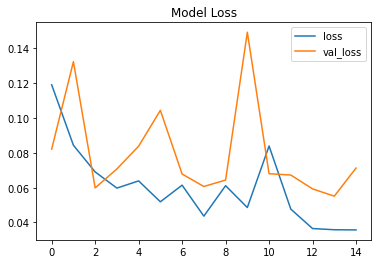

In [7]:
results[['loss','val_loss']].plot(title='Model Loss')
plt.savefig('./data/results/loss.png')

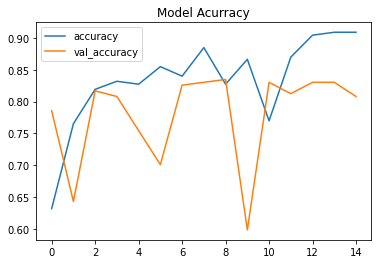

In [8]:
results[['accuracy','val_accuracy']].plot(title='Model Acurracy')
plt.savefig('./data/results/accuracy.png')

In [9]:
# Mostrar el accuracy y val_accuracy obtenidos
print("Accuracy: {}, Val_Accuracy: {}".format(results['accuracy'].iloc[-1], results['val_accuracy'].iloc[-1]))
# Mostrar el loss y val_loss obtenidos
print("Loss: {}, Val_Loss: {}".format(results['loss'].iloc[-1], results['val_loss'].iloc[-1]))

Accuracy: 0.9090909361839294, Val_Accuracy: 0.8080357313156128
Loss: 0.03572725132107735, Val_Loss: 0.07127349823713303


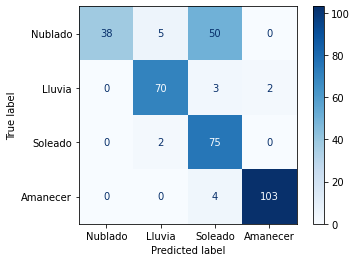

In [10]:
# Hacer confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
# concatenate n batches

class_names = ['Nublado', 'Lluvia', 'Soleado', 'Amanecer']
n = 10

image_batch, classes_batch = next(test_generator)

for batch in range(n):
    temp = next(test_generator)
    image_batch = np.concatenate((image_batch, temp[0]))
    classes_batch = np.concatenate((classes_batch, temp[1]))

classes_batch = classes_batch
y_predict = model.predict(image_batch)

ConfusionMatrixDisplay.from_predictions(
    y_true = [np.argmax(x) for x in classes_batch],
    #y_true = classes_batch.
    y_pred = [np.argmax(x) for x in y_predict],
    #y_pred = y_predict,
    display_labels=class_names,
    cmap='Blues'
)
plt.savefig('./data/results/confusion_matrix.png')                                       
plt.show()

In [11]:
def predict_one(model, num_images = None):  
    image_batch, classes_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0] if num_images is None else num_images):
        image = image_batch[k]
        real_class = class_names[np.argmax(classes_batch[k])]
        predicted_class = class_names[np.argmax(predicted_batch[k])]
        value_predicted = predicted_batch[k]
        isTrue = (real_class == predicted_class)
        plt.figure(k)
        plt.title(str("Predicción Correcta" if isTrue else "Predicción Incorrecta") + ' - class: ' + real_class + ' - ' + 'predicted: ' + predicted_class + str(value_predicted))
        plt.axis('off')
        plt.savefig('./data/results/' + real_class + '_' + predicted_class + '_' + str(value_predicted) + '.png')
        plt.imshow(image)

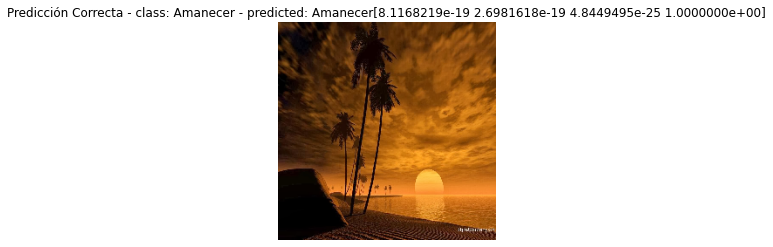

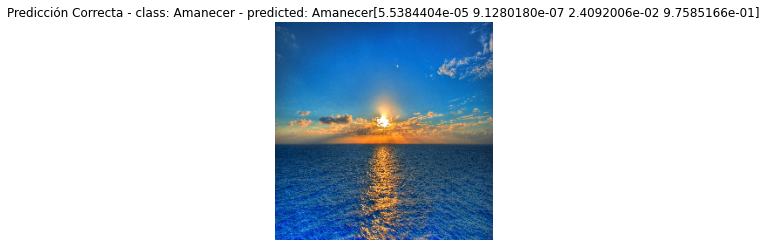

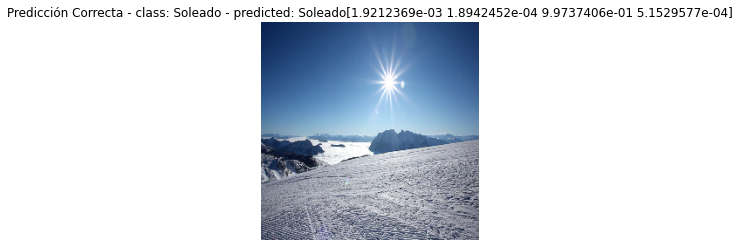

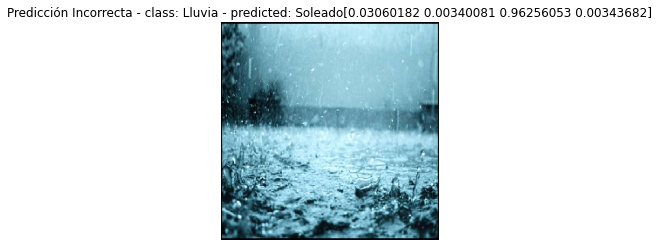

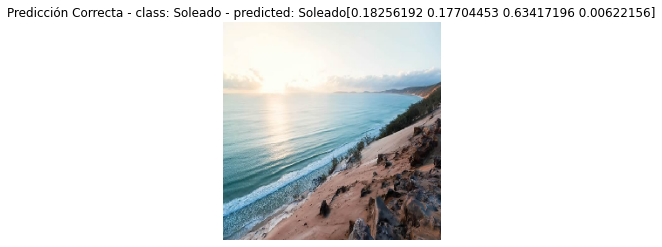

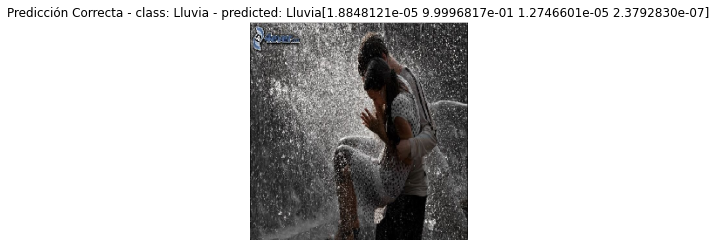

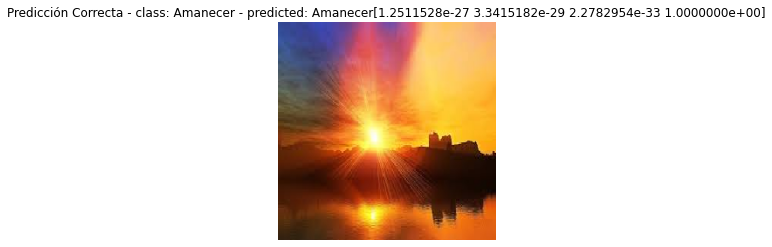

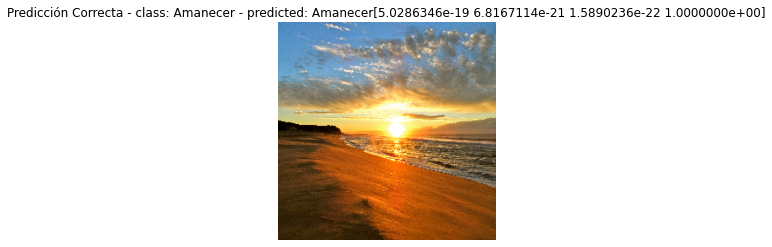

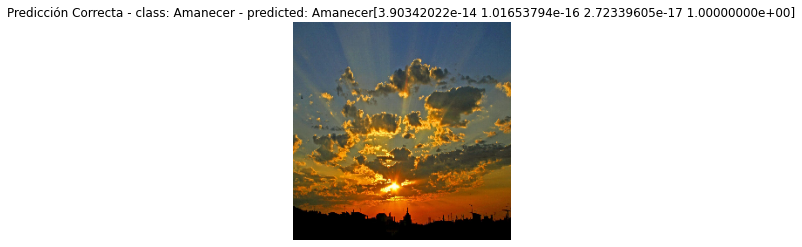

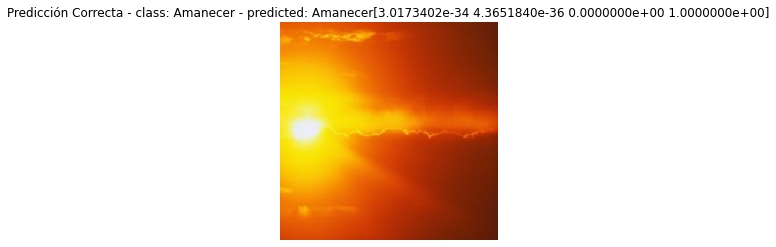

In [12]:
predict_one(model, 10)